# Importação das Bibliotecas


In [ ]:
from collections import Counter

import pandas as pd
from imblearn.over_sampling import SMOTE
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, OneHotEncoder


# Carregamento dos Dados


In [ ]:
try:
    df = pd.read_csv("data/sods.csv")
    # Exibição do DataFrame
    display(df.head())
except FileNotFoundError as error:
    print(error)
except Exception as error:
    print(error)

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...


# Análise Inicial dos Dados


<Axes: title={'center': 'Valores Ausentes por Coluna'}>

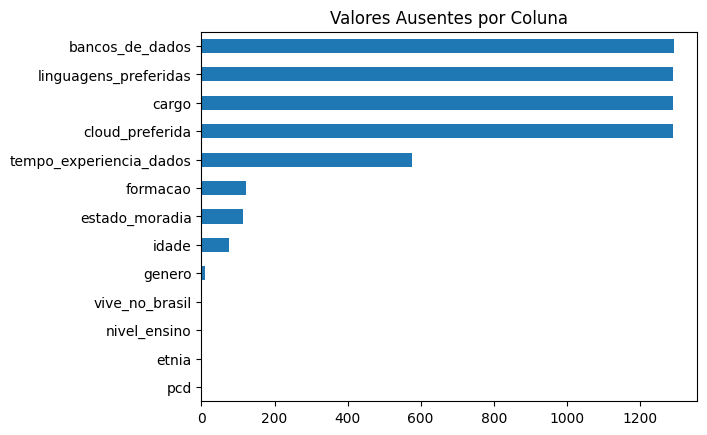

In [ ]:
# Visualização dos Valores Ausentes por Coluna
df.isnull().sum().sort_values(ascending=True).plot(
    kind="barh", title="Valores Ausentes por Coluna"
)

<Axes: title={'center': 'Distribuição de cargo'}, ylabel='cargo'>

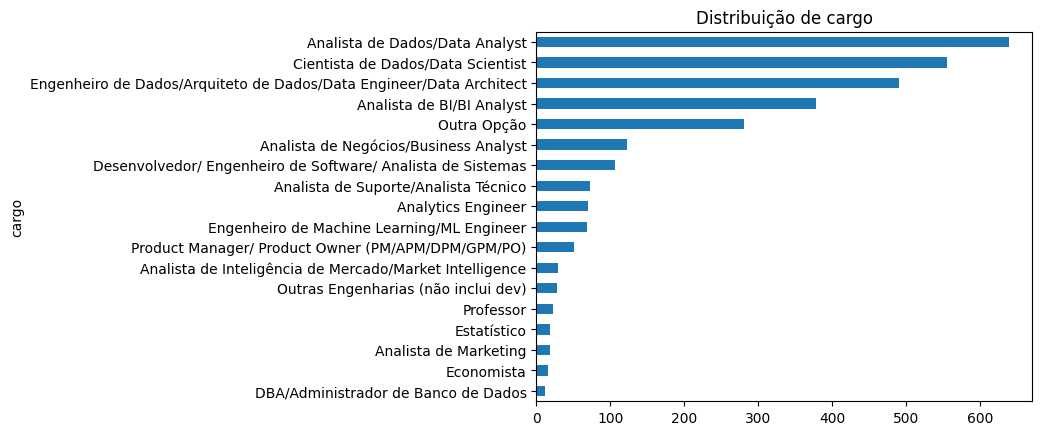

In [26]:
# Visualização da Distribuição dos Cargos
def get_cargo_distribution(df, column="cargo"):
    return (
        df[column]
        .value_counts()
        .sort_values(ascending=True)
        .plot(
            kind="barh",
            title=f"Distribuição de {column}",
        )
    )


get_cargo_distribution(df)

# Pré-Processamento


In [ ]:
# Copiando DataFrame para Pré-Processamento
pp_df = df.copy()

# Mostrando Informações do DataFrame
pp_df.info()

NameError: name 'df' is not defined

In [37]:
# Removendo Linhas com Valores Ausentes na Coluna "cargo"
pp_df = pp_df.dropna(subset=["cargo"])

# Preenchendo os Valores Ausentes na Coluna "idade" com a Mediana e Convertendo para Inteiro
pp_df["idade"] = pp_df["idade"].fillna(pp_df["idade"].median()).astype(int)

# Preenchendo os Valores Ausentes na Coluna "genero" com a Moda
pp_df["genero"] = pp_df["genero"].fillna(pp_df["genero"].mode()[0])

# Preenchendo os Valores Ausentes na Coluna "formacao" com "nenhuma"
pp_df["formacao"] = pp_df["formacao"].fillna("nenhuma")

# Removendo Quaisquer Linhas com Valores Ausentes
pp_df = pp_df.dropna()

In [ ]:
# Descartando Colunas Que Não Serão Utilizadas
pp_df = pp_df.drop(columns=["pcd", "vive_no_brasil"])

# Mostrando Informações do DataFrame
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2906 entries, 0 to 4270
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   idade                    2906 non-null   int64 
 1   genero                   2906 non-null   object
 2   etnia                    2906 non-null   object
 3   estado_moradia           2906 non-null   object
 4   nivel_ensino             2906 non-null   object
 5   formacao                 2906 non-null   object
 6   tempo_experiencia_dados  2906 non-null   object
 7   linguagens_preferidas    2906 non-null   object
 8   cloud_preferida          2906 non-null   object
 9   cargo                    2906 non-null   object
dtypes: int64(1), object(9)
memory usage: 249.7+ KB


# Transformação


In [ ]:
# Copiando DataFrame para Pré-Processamento
tt_df = pp_df.reset_index(drop=True).copy()

# Mostrando Informações do DataFrame
tt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   idade                    2906 non-null   int64 
 1   genero                   2906 non-null   object
 2   etnia                    2906 non-null   object
 3   estado_moradia           2906 non-null   object
 4   nivel_ensino             2906 non-null   object
 5   formacao                 2906 non-null   object
 6   tempo_experiencia_dados  2906 non-null   object
 7   linguagens_preferidas    2906 non-null   object
 8   cloud_preferida          2906 non-null   object
 9   cargo                    2906 non-null   object
dtypes: int64(1), object(9)
memory usage: 227.2+ KB


## Normalização de Colunas Textuais


In [ ]:
def normalize_column(column):
    return (
        column.str.lower()
        .str.strip()
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
    )


tt_df.iloc[:, 1:] = tt_df.iloc[:, 1:].apply(normalize_column)
tt_df.head()

,idade,genero,etnia,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,cloud_preferida,cargo
0,39,masculino,parda,distrito federal (df),pos-graduacao,computacao / engenharia de software / sistemas...,de 1 a 2 anos,r,amazon web services (aws),dba/administrador de banco de dados
1,53,masculino,branca,distrito federal (df),pos-graduacao,computacao / engenharia de software / sistemas...,de 3 a 4 anos,python,amazon web services (aws),desenvolvedor/ engenheiro de software/ analist...
2,27,masculino,branca,minas gerais (mg),doutorado ou phd,estatistica/ matematica / matematica computaci...,de 4 a 6 anos,python,nao sei opinar,cientista de dados/data scientist
3,46,feminino,branca,para (pa),pos-graduacao,computacao / engenharia de software / sistemas...,nao tenho experiencia na area de dados,python,amazon web services (aws),desenvolvedor/ engenheiro de software/ analist...
4,32,feminino,parda,ceara (ce),pos-graduacao,ciencias biologicas/ farmacia/ medicina/ area ...,nao tenho experiencia na area de dados,python,google cloud (gcp),professor


## Mapeamento dos Níveis de Ensino


In [ ]:
nivel_ensino_map = {
    "estudante de graduacao": 1,
    "graduacao/bacharelado": 2,
    "pos-graduacao": 3,
    "mestrado": 4,
    "doutorado ou phd": 5,
    "nao tenho graduacao formal": 0,
    "prefiro nao informar": 0,
}
tt_df["nivel_ensino"] = tt_df["nivel_ensino"].map(nivel_ensino_map)

## Mapeamento dos Tempos de Experiência


In [ ]:
tempo_experiencia_dados_map = {
    "menos de 1 ano": 0.5,
    "de 1 a 2 anos": 1.5,
    "de 3 a 4 anos": 3.5,
    "de 4 a 6 anos": 5.0,
    "de 7 a 10 anos": 8.0,
    "mais de 10 anos": 12.0,
    "nao tenho experiencia na area de dados": 0.0,
}
tt_df["tempo_experiencia_dados"] = tt_df["tempo_experiencia_dados"].map(
    tempo_experiencia_dados_map
)

## Tratamento das Linguagens Preferidas


In [ ]:
linguagens_preferidas_map = {
    "pyspark": "spark",
    "xlsx": "excel",
    "m language": "m",
    "aql": "sql",
    "sql postegres": "sql",
    "nao sei": "nenhuma",
    "nao utilizo": "nenhuma",
    "softwares estatisticos como spss": "nenhuma",
    "nao atuo com programacao": "nenhuma",
    "nenhum": "nenhuma",
    "nao uso": "nenhuma",
}
tt_df["linguagens_preferidas"] = tt_df["linguagens_preferidas"].replace(
    linguagens_preferidas_map
)

# Listando as 5 Linguagens Mais Comuns
pl_count = tt_df["linguagens_preferidas"].explode().value_counts()
common_pl = pl_count[pl_count >= 5].index

# Função de Agrupamento
tt_df["linguagens_preferidas"] = tt_df["linguagens_preferidas"].apply(
    lambda x: x if x in common_pl else "outro"
)

## Tratamento de Bancos de Dados


In [ ]:
bancos_de_dados_map = {
    "nao utilizo": "nenhum",
    "nenhuma": "nenhum",
    "nao uso": "nenhum",
    "nao utilizo nenhum": "nenhum",
    "nao atuo na area ainda": "nenhum",
    "nenhum acima": "nenhum",
    "nao sei": "nenhum",
}
tt_df["bancos_de_dados"] = tt_df["bancos_de_dados"].replace(bancos_de_dados_map)

In [ ]:
# Splitando os Bancos de Dados
tt_df["bancos_de_dados_splited"] = tt_df["bancos_de_dados"].str.lower().str.split(",")

# Contando a Frequência de Cada Banco de Dados
bd_count = Counter()
for list in tt_df["bancos_de_dados_splited"]:
    bd_count.update([item.strip() for item in list if item.strip() != ""])

# Listando os 25 Bancos de Dados Mais Comuns
top_bds = pd.Series(bd_count).sort_values(ascending=False)
common_bds = top_bds[top_bds >= 25].index


# Função de Agrupamento
def grouping_bds(lista):
    return set(
        item.strip() if item.strip() in common_bds else "outro"
        for item in lista
        if item.strip() != ""
    )


tt_df["bancos_de_dados_grouped"] = tt_df["bancos_de_dados_splited"].apply(grouping_bds)

## Multilabel Binarizer


In [ ]:
mlb = MultiLabelBinarizer()
bds_encoded = mlb.fit_transform(tt_df["bancos_de_dados_grouped"])

# Criando DataFrame com os Bancos de Dados Codificados
bds_df = pd.DataFrame(
    bds_encoded,
    columns=[f"bds_{c.replace(' ', '_')}" for c in mlb.classes_],
    index=tt_df.index,
)

# Concatenando com o DataFrame Original e Removendo Colunas Desnecessárias
tt_df = pd.concat([tt_df, bds_df], axis=1).drop(
    columns=["bancos_de_dados", "bancos_de_dados_splited", "bancos_de_dados_grouped"]
)
tt_df.head()

,idade,genero,etnia,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,cloud_preferida,cargo,...,bds_outro,bds_postgresql,bds_presto,bds_redis,bds_s3,bds_sap_hana,bds_snowflake,bds_splunk,bds_sql_server,bds_sqlite
0,39,masculino,parda,distrito federal (df),3,computacao / engenharia de software / sistemas...,1.5,r,amazon web services (aws),dba/administrador de banco de dados,...,0,1,0,0,0,0,0,0,1,0
1,53,masculino,branca,distrito federal (df),3,computacao / engenharia de software / sistemas...,3.5,python,amazon web services (aws),desenvolvedor/ engenheiro de software/ analist...,...,0,1,0,0,0,0,0,0,0,0
2,27,masculino,branca,minas gerais (mg),5,estatistica/ matematica / matematica computaci...,5.0,python,nao sei opinar,cientista de dados/data scientist,...,0,0,0,0,0,0,0,0,0,0
3,46,feminino,branca,para (pa),3,computacao / engenharia de software / sistemas...,0.0,python,amazon web services (aws),desenvolvedor/ engenheiro de software/ analist...,...,0,0,0,0,0,0,0,0,0,0
4,32,feminino,parda,ceara (ce),3,ciencias biologicas/ farmacia/ medicina/ area ...,0.0,python,google cloud (gcp),professor,...,0,0,0,0,0,0,0,0,0,0


## One Hot Encoder


In [ ]:
# Identificando Colunas Categóricas
categorical_columns = tt_df.select_dtypes(include=["object", "bool"]).columns.drop(
    "cargo"
)

# Aplicando One Hot Encoder
ohe_encoder = OneHotEncoder(sparse_output=False)
encoded_data = ohe_encoder.fit_transform(tt_df[categorical_columns])
new_columns = ohe_encoder.get_feature_names_out(categorical_columns)

# Criando DataFrame com os Dados Codificados
df_ohe = pd.DataFrame(encoded_data, columns=new_columns)
df_not_phe = tt_df.drop(columns=categorical_columns)

# Concatenando com o DataFrame Original e Removendo Colunas Categóricas
tt_df = pd.concat([df_not_phe, df_ohe], axis=1)
tt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 91 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   idade                                                                            2906 non-null   int64  
 1   nivel_ensino                                                                     2906 non-null   int64  
 2   tempo_experiencia_dados                                                          2906 non-null   float64
 3   cargo                                                                            2906 non-null   object 
 4   bds_amazon_athena                                                                2906 non-null   int64  
 5   bds_amazon_aurora_ou_rds                                                         2906 non-null   int64  
 6   bds_amaz

## Label Encoder


In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(tt_df["cargo"])

# Inserindo a Coluna Codificada no DataFrame e Removendo a Original
tt_df = tt_df.drop(columns=["cargo"])
tt_df["cargo_label_encoded"] = encoded_label
tt_df["cargo_label_encoded"]

0        8
1        9
2        7
3        9
4       17
        ..
2901     3
2902     1
2903    11
2904    14
2905     1
Name: cargo_label_encoded, Length: 2906, dtype: int64

# Treinamento


<Axes: title={'center': 'Distribuição de cargo_label_encoded'}, ylabel='cargo_label_encoded'>

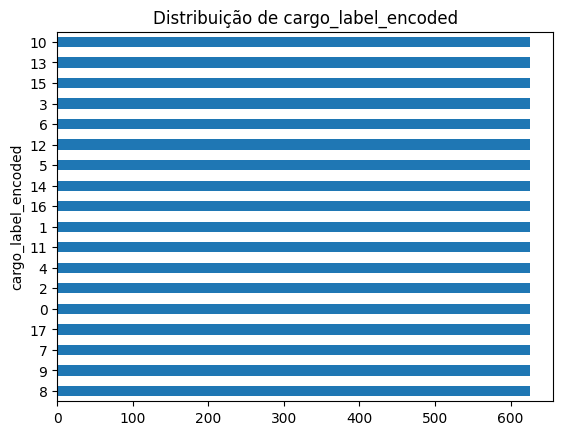

In [ ]:
# Separando os Dados em Variáveis Independentes (X) e Dependentes (y)
X = tt_df.drop(columns=["cargo_label_encoded"])
y = tt_df["cargo_label_encoded"]

# Aplicando SMOTE para Balanceamento de Classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualizando a Distribuição das Classes Após o Balanceamento
get_cargo_distribution(y_resampled.to_frame(), column="cargo_label_encoded")

In [19]:
# Dividindo os Dados em Conjuntos de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Mostrando as Formas dos Conjuntos de Dados
print(f"X_train shape:{X_train.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape:{y_test.shape}")

X_train shape:(7875, 90)
y_train shape:(7875,)
X_test shape:(3375, 90)
y_test shape:(3375,)


## Random Forest Classifier


RandomForestClassifier → Best Params: {'n_estimators': 600, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}


,accuracy,precision,recall,f1
train,0.982476,0.982765,0.982476,0.982517
test,0.802074,0.793157,0.802074,0.794782


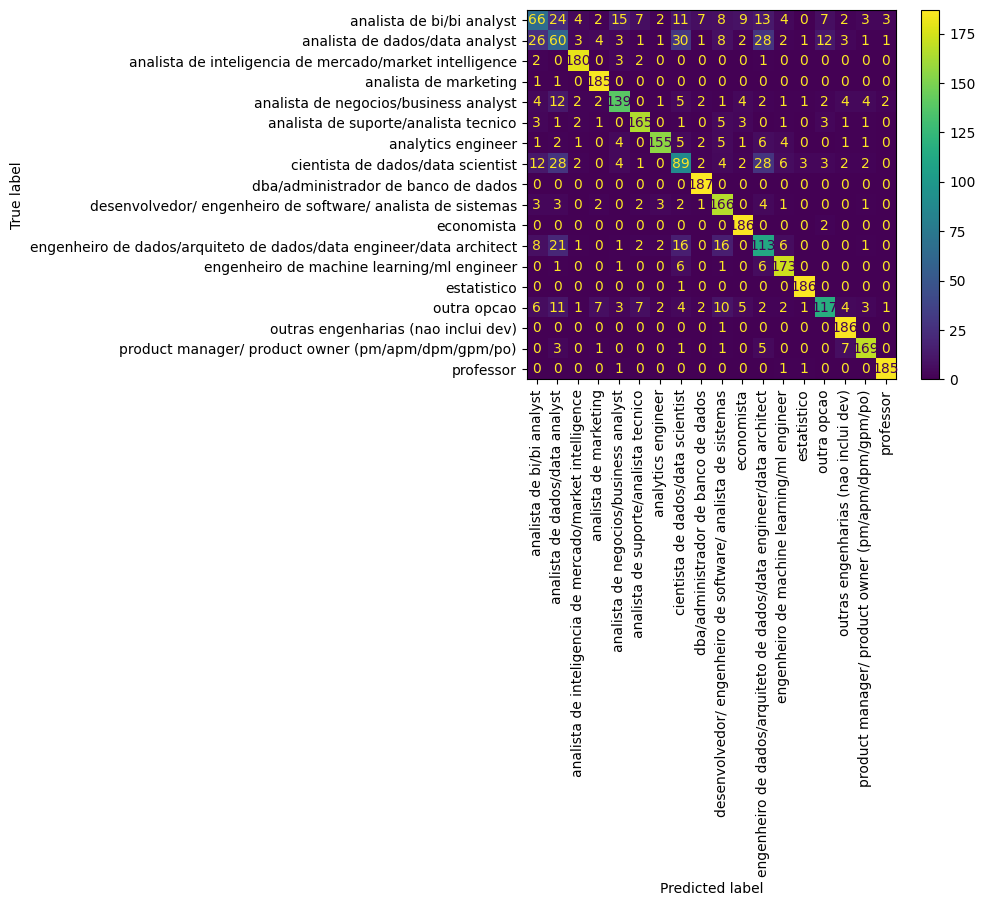

In [ ]:
rf_params = {
    "n_estimators": [400, 500, 600],
    "max_depth": [10, None],
    "min_samples_leaf": [2, 3, 5],
    "max_features": ["sqrt"],
    "class_weight": ["balanced"],
}
random_forest = RandomForestClassifier(random_state=42)

# Executando o Randomized Search CV
rf_search = RandomizedSearchCV(random_forest, rf_params, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Métricas de Treino
y_train_pred = rf_search.predict(X_train)
train_metrics = {
    "accuracy": accuracy_score(y_train, y_train_pred),
    "precision": precision_score(
        y_train, y_train_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_train, y_train_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_train, y_train_pred, average="weighted", zero_division=0),
}

# Métricas de Teste
y_test_pred = rf_search.predict(X_test)
test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(
        y_test, y_test_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_test, y_test_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_test, y_test_pred, average="weighted", zero_division=0),
}

# Visualização da Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(
    xticks_rotation="vertical",
)

# Visualização das Métricas de Avaliação
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["train", "test"])
print(f"{random_forest.__class__.__name__} → Best Params: {rf_search.best_params_}")
display(metrics_df)

## MLP Classifier


MLPClassifier → Best Params: {'validation_fraction': 0.1, 'tol': 0.0001, 'solver': 'adam', 'n_iter_no_change': 20, 'max_iter': 1200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 128), 'early_stopping': True, 'batch_size': 128, 'alpha': 0.01, 'activation': 'tanh'}


,accuracy,precision,recall,f1
train,0.953143,0.953668,0.953143,0.952800
test,0.783704,0.780516,0.783704,0.779165


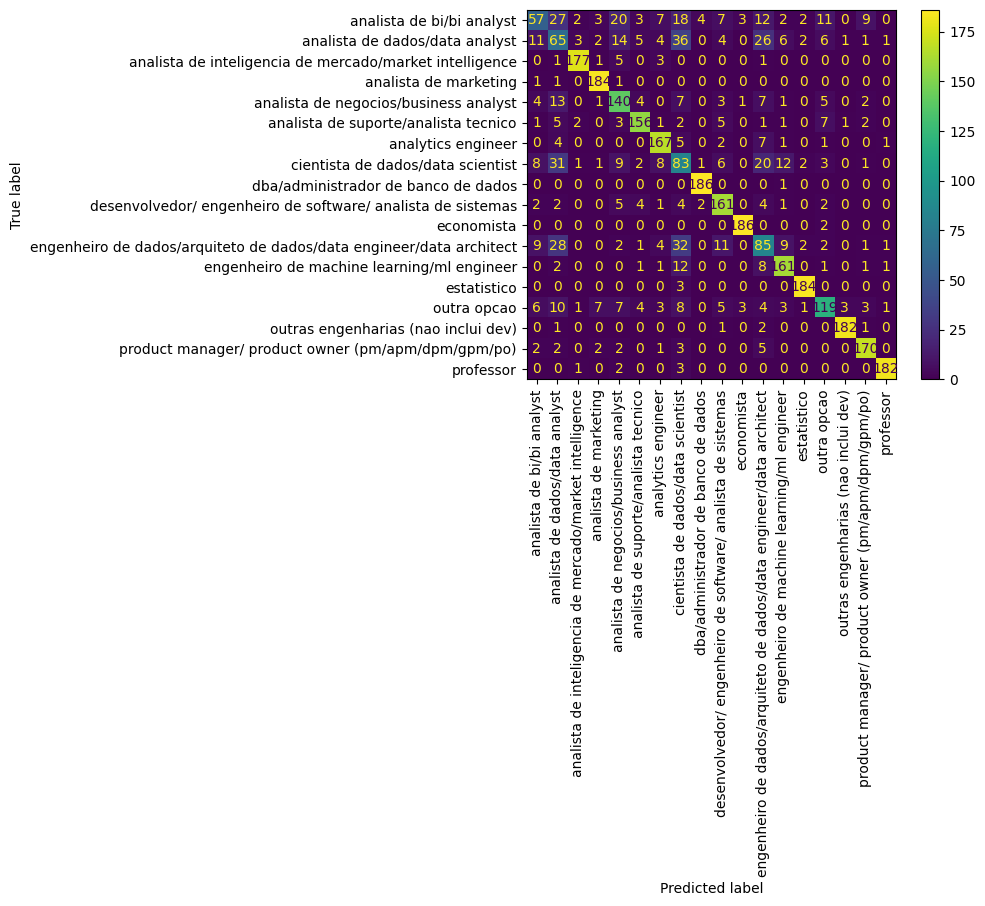

In [ ]:
mlp_params = {
    "hidden_layer_sizes": [(64, 64), (128, 64), (128, 128)],
    "activation": ["tanh", "relu"],
    "solver": ["adam"],
    "alpha": [0.001, 0.003, 0.01, 0.03],
    "batch_size": [64, 128],
    "learning_rate_init": [0.0005, 0.0008, 0.001],
    "max_iter": [800, 1200],
    "tol": [1e-4, 1e-5],
    "early_stopping": [True],
    "validation_fraction": [0.1, 0.2],
    "n_iter_no_change": [10, 20],
}
neural_network = MLPClassifier(random_state=42)

# Executando o Randomized Search CV
mlp_search = RandomizedSearchCV(neural_network, mlp_params, n_jobs=-1, random_state=42)
mlp_search.fit(X_train, y_train)

# Métricas de Treino
y_train_pred = mlp_search.predict(X_train)
train_metrics = {
    "accuracy": accuracy_score(y_train, y_train_pred),
    "precision": precision_score(
        y_train, y_train_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_train, y_train_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_train, y_train_pred, average="weighted", zero_division=0),
}

# Métricas de Teste
y_test_pred = mlp_search.predict(X_test)
test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(
        y_test, y_test_pred, average="weighted", zero_division=0
    ),
    "recall": recall_score(y_test, y_test_pred, average="weighted", zero_division=0),
    "f1": f1_score(y_test, y_test_pred, average="weighted", zero_division=0),
}

# Visualização da Matriz de Confusão
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(
    xticks_rotation="vertical",
)

# Visualização das Métricas de Avaliação
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["train", "test"])
print(f"{neural_network.__class__.__name__} → Best Params: {mlp_search.best_params_}")
display(metrics_df)

## Salvando os Modelos


In [ ]:
# Salvando o Modelo Random Forest
dump(rf_search.best_estimator_, "models/random_forest_model.joblib")

# Salvando o Modelo Neural Network
dump(mlp_search.best_estimator_, "models/neural_network_model.joblib")

# Salvando os Encoders
dump(label_encoder, "models/label_encoder.joblib")
dump(mlb, "models/mlb_encoder.joblib")
dump(ohe_encoder, "models/ohe_encoder.joblib")
print("Modelos e Encoders salvos na pasta 'models/'")

Modelos e Encoders salvos na pasta 'models/'
